In [1]:
import pandas as pd
import re

# Load the data from the Excel file
data_path = r'D:\ATMD\analysis_survey.xlsx'
data = pd.read_excel(data_path)

import pandas as pd
import re

# Load the data from the Excel file
data_path = r'D:\ATMD\analysis_survey.xlsx'
data = pd.read_excel(data_path)

# Rename columns for easier access
data.columns = ['1yr_inflation', '3yr_inflation', 'news_frequency']

def clean_inflation_data(value):
    # Handling text responses and missing values
    if pd.isna(value) or any(phrase in str(value).lower() for phrase in ["don't know", "not sure", "no idea"]):
        return pd.NA
    # Removing all non-numeric characters except the period and minus sign
    cleaned_value = re.sub(r'[^\d.-]', '', str(value))
    try:
        # Convert to float, handling ranges by taking the average
        if '-' in cleaned_value:
            # Split the range, convert each part to a float, and calculate the average
            parts = list(map(float, cleaned_value.split('-')))
            return sum(parts) / len(parts) / 100  # Adjust for percentage if necessary
        else:
            # Convert direct numbers assuming they are meant as percentages
            num = float(cleaned_value)
            return num / 100 if num > 1 else num  # Adjust if it seems to be a whole number percentage
    except ValueError:
        return pd.NA


# Apply the cleaning function to the inflation columns
data['1yr_inflation'] = data['1yr_inflation'].apply(clean_inflation_data)
data['3yr_inflation'] = data['3yr_inflation'].apply(clean_inflation_data)


# Display the cleaned data
print(data)



   1yr_inflation 3yr_inflation  news_frequency
0           <NA>          <NA>               3
1            0.2          0.27               4
2           0.04          0.15               5
3           0.05           0.1               3
4            0.1           0.2               4
5           0.04           0.1               1
6           0.02          0.04               4
7           0.05           0.1               4
8           <NA>          <NA>               4
9           <NA>          <NA>               2
10          <NA>          0.05               5
11           0.1          <NA>               5
12          <NA>          <NA>               3
13          0.02          0.05               1
14          0.05          <NA>               4
15          0.45          <NA>               5
16          0.07           0.1               5
17          0.07          0.05               4
18          <NA>          <NA>               4
19          <NA>          <NA>               2
20         0.

In [29]:
# Drop NA values for correlation analysis
clean_data = data.dropna(subset=['1yr_inflation'])

# Calculate correlation between news frequency and 1-year inflation expectations
correlation = clean_data['news_frequency'].corr(clean_data['1yr_inflation'])
print("Correlation between news frequency and 1-year inflation expectations:", correlation)


Correlation between news frequency and 1-year inflation expectations: 0.3121678779708686


In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure the DataFrame 'data' is correctly loaded and columns are appropriately named
print(data.columns)  # This will help you confirm column names


Index(['1yr_inflation', '3yr_inflation', 'news_frequency'], dtype='object')


In [4]:
# Ensure the correct number of columns are named
data.columns = ['1yr_inflation', '3yr_inflation', 'news_frequency']

# Convert '1yr_inflation' to numeric, coercing errors to NaN
data['1yr_inflation'] = pd.to_numeric(data['1yr_inflation'], errors='coerce')

# Convert 'news_frequency' to a categorical variable
data['news_frequency'] = pd.Categorical(data['news_frequency'])

# Drop rows with missing '1yr_inflation'
data.dropna(subset=['1yr_inflation'], inplace=True)

# Check data for consistency
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 1 to 37
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   1yr_inflation   23 non-null     float64 
 1   3yr_inflation   18 non-null     object  
 2   news_frequency  23 non-null     category
dtypes: category(1), float64(1), object(1)
memory usage: 787.0+ bytes
None


In [5]:
import pandas as pd
import statsmodels.api as sm

# Drop rows with missing values in relevant columns
cleaned_data = data.dropna(subset=['1yr_inflation', 'news_frequency'])

# Convert news_frequency into dummy variables
dummies = pd.get_dummies(cleaned_data['news_frequency'], prefix='news', drop_first=True)
y = data['1yr_inflation'].astype(float)
X = dummies.astype(float)  # Ensure dummy variables are numeric

# Step 2: Add a constant for the intercept
X = sm.add_constant(X)

# Step 3: Check for NaN values and drop rows with missing data
X = X.dropna()
y = y.loc[X.index]  # Ensure the indices of `y` match those of `X`

# Step 4: Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Step 5: Output the summary of the regression
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:          1yr_inflation   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.9234
Date:                Thu, 09 Jan 2025   Prob (F-statistic):              0.472
Time:                        07:52:11   Log-Likelihood:                 25.208
No. Observations:                  23   AIC:                            -40.42
Df Residuals:                      18   BIC:                            -34.74
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0300      0.065      0.464      0.6

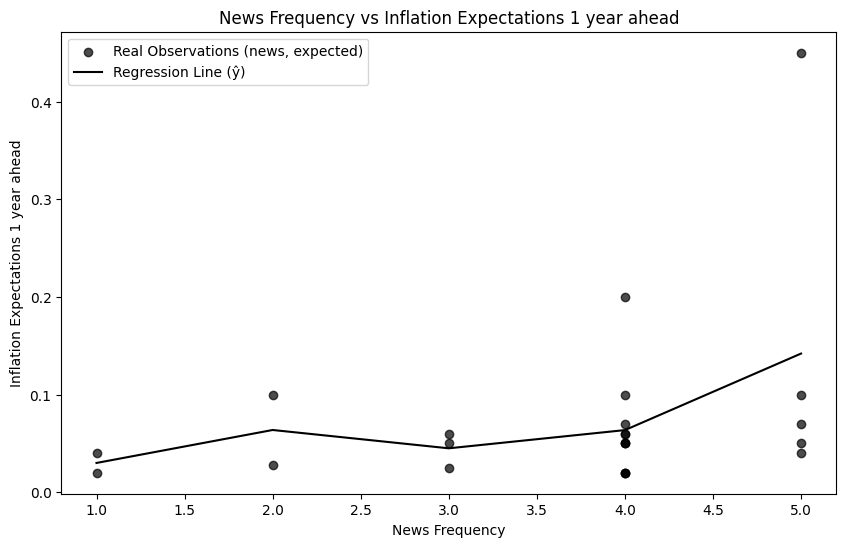

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data
news = cleaned_data['news_frequency']  # Independent variable (x-axis)
observed = y  # Observed inflation (real y values)
fitted = model.fittedvalues  # Predicted inflation (ŷ)

# Create a sorted version of news for smoother regression line
sorted_news = np.sort(news)
predicted_line = model.predict(sm.add_constant(pd.get_dummies(sorted_news, prefix='news', drop_first=True)))

# Plot the real observations (dots)
plt.figure(figsize=(10, 6))
plt.scatter(news, observed, color='black', label='Real Observations (news, expected)', alpha=0.7)

# Plot the regression line
plt.plot(sorted_news, predicted_line, color='black', label='Regression Line (ŷ)', linewidth=1.5)

# Add labels, title, and legend
plt.title('News Frequency vs Inflation Expectations 1 year ahead')
plt.xlabel('News Frequency')
plt.ylabel('Inflation Expectations 1 year ahead')
plt.legend()
plt.show()


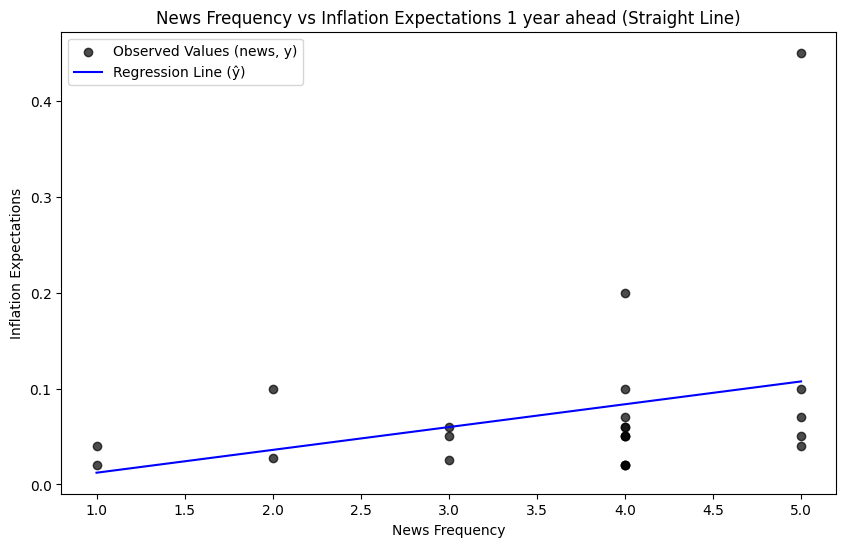

In [7]:
# Use news_frequency as a numeric variable
X_numeric = sm.add_constant(cleaned_data['news_frequency'].astype(float))  # Add intercept
y_numeric = cleaned_data['1yr_inflation']

# Fit the OLS regression model
model_numeric = sm.OLS(y_numeric, X_numeric).fit()

# Extract fitted values and predicted line
news_sorted = np.sort(cleaned_data['news_frequency'])
predicted_line = model_numeric.predict(sm.add_constant(news_sorted))

# Plot observed vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['news_frequency'], cleaned_data['1yr_inflation'], color='black', label='Observed Values (news, y)', alpha=0.7)
plt.plot(news_sorted, predicted_line, color='blue', label='Regression Line (ŷ)', linewidth=1.5)
plt.title('News Frequency vs Inflation Expectations 1 year ahead (Straight Line)')
plt.xlabel('News Frequency')
plt.ylabel('Inflation Expectations')
plt.legend()
plt.show()
